# 5. 멀티모달 딥러닝

copy from https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

In [1]:
!git clone https://github.com/emanhamed/Houses-dataset

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2165
Receiving objects: 100% (2166/2166), 176.26 MiB | 19.59 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [2]:
!pip install opencv-python

In [3]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2  # 이미지 처리하는 패키지
import os

def load_house_attributes(inputPath):
	# initialize the list of column names in the CSV file and then
	# load it using Pandas
	cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
	df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)

	# determine (1) the unique zip codes and (2) the number of data
	# points with each zip code
	zipcodes = df["zipcode"].value_counts().keys().tolist()
	counts = df["zipcode"].value_counts().tolist()

	# loop over each of the unique zip codes and their corresponding
	# count
	for (zipcode, count) in zip(zipcodes, counts):
		# the zip code counts for our housing dataset is *extremely*
		# unbalanced (some only having 1 or 2 houses per zip code)
		# so let's sanitize our data by removing any houses with less
		# than 25 houses per zip code
		if count < 25:
			idxs = df[df["zipcode"] == zipcode].index
			df.drop(idxs, inplace=True)

	# return the data frame
	return df

def process_house_attributes(df, train, test):
	# initialize the column names of the continuous data
	continuous = ["bedrooms", "bathrooms", "area"]

	# performin min-max scaling each continuous feature column to
	# the range [0, 1]
	cs = MinMaxScaler()
	trainContinuous = cs.fit_transform(train[continuous])
	testContinuous = cs.transform(test[continuous])

	# one-hot encode the zip code categorical data (by definition of
	# one-hot encoing, all output features are now in the range [0, 1])
	zipBinarizer = LabelBinarizer().fit(df["zipcode"])
	trainCategorical = zipBinarizer.transform(train["zipcode"])
	testCategorical = zipBinarizer.transform(test["zipcode"])

	# construct our training and testing data points by concatenating
	# the categorical features with the continuous features
	trainX = np.hstack([trainCategorical, trainContinuous])
	testX = np.hstack([testCategorical, testContinuous])

	# return the concatenated training and testing data
	return (trainX, testX)

def load_house_images(df, inputPath):
	# initialize our images array (i.e., the house images themselves)
	images = []

	# loop over the indexes of the houses
	for i in df.index.values:
		# find the four images for the house and sort the file paths,
		# ensuring the four are always in the *same order*
		basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
		housePaths = sorted(list(glob.glob(basePath)))

		# initialize our list of input images along with the output image
		# after *combining* the four input images
		inputImages = []
		outputImage = np.zeros((64, 64, 3), dtype="uint8")

		# loop over the input house paths
		for housePath in housePaths:
			# load the input image, resize it to be 32 32, and then
			# update the list of input images
			image = cv2.imread(housePath) # 이미지 넣기
			image = cv2.resize(image, (32, 32))
			inputImages.append(image)

		# tile the four input images in the output image such the first
		# image goes in the top-right corner, the second image in the
		# top-left corner, the third image in the bottom-right corner,
		# and the final image in the bottom-left corner
		outputImage[0:32, 0:32] = inputImages[0]
		outputImage[0:32, 32:64] = inputImages[1]
		outputImage[32:64, 32:64] = inputImages[2]
		outputImage[32:64, 0:32] = inputImages[3]

		# add the tiled image to our set of images the network will be
		# trained on
		images.append(outputImage)

	# return our set of images
	return np.array(images)

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

def create_mlp(dim, regress=False): # 집의 특징이 나온 정형데이터는 DNN으로
	# define our MLP network
	model = Sequential()
	model.add(Dense(8, input_dim=dim, activation="relu"))
	model.add(Dense(4, activation="relu"))

	# check to see if the regression node should be added
	if regress:
		model.add(Dense(1, activation="linear"))

	# return our model
	return model

def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False): # 이미지는 CNN으로
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1

	# define the model input
	inputs = Input(shape=inputShape)

	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs

		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)

	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(16)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Dropout(0.5)(x)

	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(4)(x)
	x = Activation("relu")(x)

	# check to see if the regression node should be added
	if regress:
		x = Dense(1, activation="linear")(x)

	# construct the CNN
	model = Model(inputs, x)

	# return the CNN
	return model

In [ ]:
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import concatenate

import numpy as np
import argparse
import locale
import matplotlib.pyplot as plt

import os

In [ ]:
df = load_house_attributes("Houses-dataset/Houses Dataset/HousesInfo.txt")
df.head()

,bedrooms,bathrooms,area,zipcode,price
30,5,3.0,2520,93446,789000
32,3,2.0,1802,93446,365000
39,3,3.0,2146,93446,455000
80,4,2.5,2464,91901,599000
81,2,2.0,1845,91901,529800


(362, 64, 64, 3)


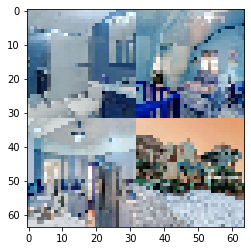

In [ ]:
images = load_house_images(df, 'Houses-dataset/Houses Dataset')
print(images.shape) # 4개가 한쌍
plt.imshow(images[0])
images = images / 255.0

In [ ]:
(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(df, images, test_size=0.25, random_state=42)

In [ ]:
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

In [ ]:
(trainAttrX, testAttrX) = process_house_attributes(df, trainAttrX, testAttrX)

In [ ]:
mlp = create_mlp(trainAttrX.shape[1], regress=False) #함수 사용해서 모델만들기
cnn = create_cnn(64, 64, 3, regress=False)  #함수 사용해서 모델만들기

combinedInput = concatenate([mlp.output, cnn.output]) # 두 모델을 합치는 함수

x = Dense(4, activation="relu")(combinedInput)
output = Dense(1, activation="linear")(x)



model = Model(inputs=[mlp.input, cnn.input], outputs=output)

optimizer = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=optimizer)

model.fit(
	[trainAttrX, trainImagesX], trainY, # [X1과 X2묶음], Y는 집값
	validation_data=([testAttrX, testImagesX], testY),
	epochs=100, batch_size=512)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 563.2110 - val_loss: 249.7391
Epoch 2/100
1/1 [==============================] - 0s 117ms/step - loss: 567.1895 - val_loss: 280.7059
Epoch 3/100
1/1 [==============================] - 0s 102ms/step - loss: 428.9786 - val_loss: 303.7281
Epoch 4/100
1/1 [==============================] - 0s 131ms/step - loss: 429.4800 - val_loss: 364.8227
Epoch 5/100
1/1 [==============================] - 0s 121ms/step - loss: 396.8801 - val_loss: 372.5712
Epoch 6/100
1/1 [==============================] - 0s 127ms/step - loss: 392.5815 - val_loss: 361.5590
Epoch 7/100
1/1 [==============================] - 0s 111ms/step - loss: 411.7657 - val_loss: 324.3030
Epoch 8/100
1/1 [==============================] - 0s 118ms/step - loss: 371.8220 - val_loss: 289.1182
Epoch 9/100
1/1 [==============================] - 0s 161ms/step - loss: 344.2249 - val_loss: 257.2603
Epoch 10/100
1/1 [==============================] - 0s 145ms/step - loss: 30

Epoch 81/100
1/1 [==============================] - 0s 95ms/step - loss: 77.7809 - val_loss: 71.6159
Epoch 82/100
1/1 [==============================] - 0s 85ms/step - loss: 76.3026 - val_loss: 71.6067
Epoch 83/100
1/1 [==============================] - 0s 90ms/step - loss: 69.7395 - val_loss: 71.5968
Epoch 84/100
1/1 [==============================] - 0s 90ms/step - loss: 78.1959 - val_loss: 71.5839
Epoch 85/100
1/1 [==============================] - 0s 90ms/step - loss: 73.6271 - val_loss: 71.5726
Epoch 86/100
1/1 [==============================] - 0s 90ms/step - loss: 79.4176 - val_loss: 71.5494
Epoch 87/100
1/1 [==============================] - 0s 82ms/step - loss: 77.5768 - val_loss: 71.5288
Epoch 88/100
1/1 [==============================] - 0s 90ms/step - loss: 75.6086 - val_loss: 71.5120
Epoch 89/100
1/1 [==============================] - 0s 75ms/step - loss: 70.8985 - val_loss: 71.5017
Epoch 90/100
1/1 [==============================] - 0s 98ms/step - loss: 69.8785 - val_loss

In [ ]:
preds = model.predict([testAttrX, testImagesX])

diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df["price"].mean(), grouping=True),
	locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 71.57%, std: 22.21%
